In [82]:
import pandas as pd
import numpy as np 
import sketch 
import matplotlib.pyplot as plt 
import seaborn as sns  
import sketch

%matplotlib inline 
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format',lambda x: '%.2f' % x)

# Regression time forescasting

## Hints

Machine Learning Regression (Time Series)
* Tujuan dari pembuatan model machine learning ini
adalah untuk dapat memprediksi total quantity harian
dari product yang terjual.
* Data cleansing terlebih dahulu, merubah tipe data
supaya sesuai
* Data merge untuk menggabungkan semua data
* Membuat data baru untuk regression, yaitu groupby by
date lalu yang di aggregasi adalah qty di sum
* Akan ada sekitar 365 rows
* Menggunakan metode time series ARIMA

In [83]:
df_transaction = pd.read_csv('./data/Transaction.csv', index_col='Date', parse_dates=True, sep=';', dayfirst=True)
df_transaction.head()

,TransactionID,CustomerID,ProductID,Price,Qty,TotalAmount,StoreID
Date,,,,,,,
2022-01-01,TR11369,328,P3,7500,4,30000,12
2022-01-01,TR16356,165,P9,10000,7,70000,1
2022-01-01,TR1984,183,P1,8800,4,35200,4
2022-01-01,TR35256,160,P1,8800,7,61600,4
2022-01-01,TR41231,386,P9,10000,1,10000,4


In [84]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5020 entries, 2022-01-01 to 2022-12-31
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   ProductID      5020 non-null   object
 3   Price          5020 non-null   int64 
 4   Qty            5020 non-null   int64 
 5   TotalAmount    5020 non-null   int64 
 6   StoreID        5020 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 313.8+ KB


Data ini bebas dari dari missing values dan tipe dari setiap kolom sudah sesuai, jadi siap untuk dilakukan permodelan

In [85]:
model_df = df_transaction.groupby(level=0).agg({'Qty':'sum'})

In [86]:
model_df.rename(columns={'Qty':'Total_Qty'}, inplace=True)

In [87]:
model_df.head()

,Total_Qty
Date,
2022-01-01,49
2022-01-02,59
2022-01-03,63
2022-01-04,45
2022-01-05,30


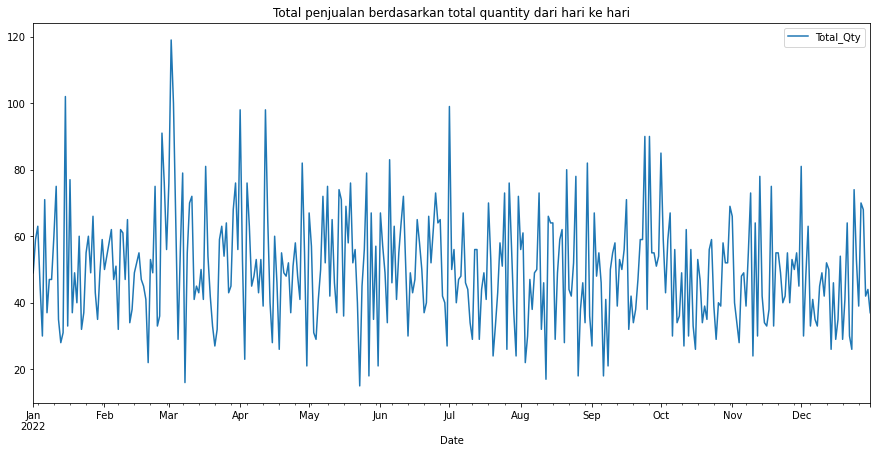

In [88]:
model_df.plot(title='Total penjualan berdasarkan total quantity dari hari ke hari', figsize=(15, 7))
plt.show();

Jika kita melihat grafik di atas maka kita akan dapat menemukan tren bahwa ada waktu dimana penjualan tinggi dan sebaliknya. Itu berarti kita dapat melihat data mengikuti musiman. Untuk ARIMA, hal pertama yang kita lakukan adalah mengidentifikasi apakah data tersebut stasioner atau tidak stasioner. jika data tidak stasioner maka kita akan mencoba membuatnya stasioner dan kemudian kita akan memproses lebih lanjut.

Mari kita periksa apakah dataset yang diberikan stasioner atau tidak, untuk itu kita menggunakan adfuller

In [89]:
from statsmodels.tsa.stattools import adfuller

test_result = adfuller(model_df['Total_Qty'])

Untuk mengidentifikasi sifat data, kita akan menggunakan hipotesis nol.

* H0: Hipotesis nol: Hipotesis nol adalah pernyataan tentang populasi yang diyakini benar atau digunakan untuk mengajukan argumen kecuali jika pernyataan tersebut dapat dibuktikan salah tanpa keraguan.

* H1: Hipotesis alternatif: Ini adalah klaim tentang populasi yang berlawanan dengan H0 dan apa yang kita simpulkan ketika kita menolak H0.

In [90]:
def adfuller_test(sales):
    result = adfuller(sales)
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations']
    for value, label in zip(result, labels):
        print(f'{label} : {value}')
    
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary')
    else:
        print('Weak evidence against the null hypothesis, indicating it is non-stationary')
    


adfuller_test(model_df['Total_Qty'])

ADF Test Statistic : -19.448086319449082
p-value : 0.0
#Lags Used : 0
Number of Observations : 364
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


Di sini P-value adalah 0.0 yang lebih besar dari 0.05, yang berarti data menerima hipotesis nol, yang berarti data tidak stasioner

Mari coba kita lihat perbedaan pertama dan perbedaan musim

In [91]:
model_df['sales_first_difference'] = model_df['Total_Qty'] - model_df['Total_Qty'].shift(1)
model_df['seasonal_first_difference'] = model_df['Total_Qty'] - model_df['Total_Qty'].shift(12)
model_df.head()

,Total_Qty,sales_first_difference,seasonal_first_difference
Date,,,
2022-01-01,49,NaN,NaN
2022-01-02,59,10.00,NaN
2022-01-03,63,4.00,NaN
2022-01-04,45,-18.00,NaN
2022-01-05,30,-15.00,NaN


In [92]:
# Uji data lagi jika data tersebut stasioner
adfuller_test(model_df['seasonal_first_difference'].dropna())

ADF Test Statistic : -8.679563667920464
p-value : 4.322883783680434e-14
#Lags Used : 11
Number of Observations : 341
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


Berdasarkan hasil testing menunjukkan P-value adalah 4.322, yang berarti kita menolak hipotesis nol, berarti data ini adalah stasioner

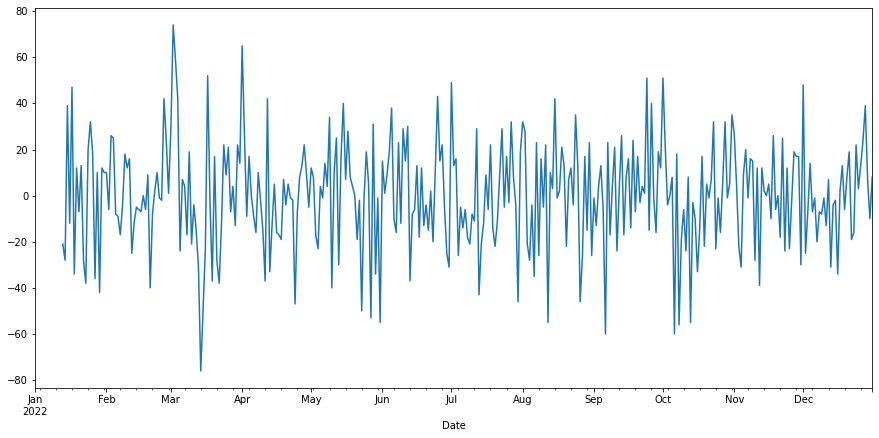

In [93]:
model_df['seasonal_first_difference'].plot(figsize=(15, 7));

Kita akan membuat auto-correlation

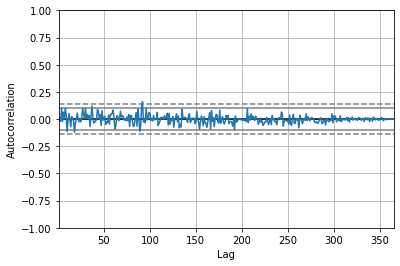

In [94]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(model_df['Total_Qty'])
plt.show();

C:\Users\hp\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


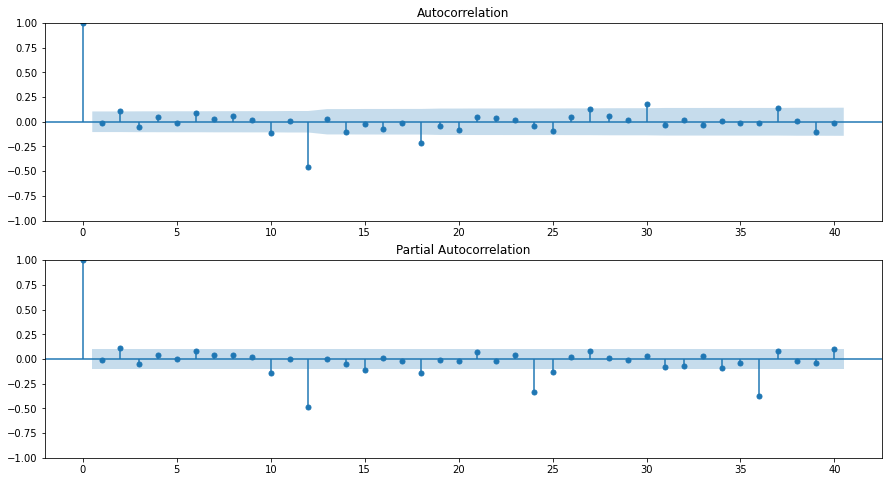

In [95]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm    

fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(model_df['seasonal_first_difference'].dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(model_df['seasonal_first_difference'].dropna(), lags=40, ax=ax2)

Tentukan parameter p,q,d untuk model ARIMA:
* p: Order autoregressive (AR), yaitu jumlah lag nilai sebelumnya yang akan digunakan sebagai prediktor.
* q: Order moving average (MA), yaitu jumlah lag dari residual error yang akan dimasukkan ke dalam model.
* d: Degree of differencing (D), yaitu jumlah kali proses diferensiasi dilakukan pada data untuk membuatnya stasioner.

In [96]:
# for non-seasonal data
# p=1, d=1, q=0 or 1

from statsmodels.tsa.arima_model import ARIMA 
import statsmodels.api as sm 
model = sm.tsa.arima.ARIMA(model_df['Total_Qty'], order=(1,1,1))
model_fit = model.fit() 
model_fit.summary()

C:\Users\hp\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Total_Qty   No. Observations:                  365
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1542.558
Date:                Mon, 10 Jul 2023   AIC                           3091.116
Time:                        10:51:52   BIC                           3102.807
Sample:                    01-01-2022   HQIC                          3095.763
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0369      0.047     -0.790      0.430      -0.129       0.055
ma.L1         -0.9853      0.012    -78.994      0.000      -1.010      -0.961
sigma2       278.0866     18.494     15.037      0.000     241.840     314.334
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                26.13
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                             0.57
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [97]:
model_df.index.values.min()

numpy.datetime64('2022-01-01T00:00:00.000000000')

In [98]:
model_df.index.values.max()

numpy.datetime64('2022-12-31T00:00:00.000000000')

Melakukan prediksi dengan model yang telah dilatih:

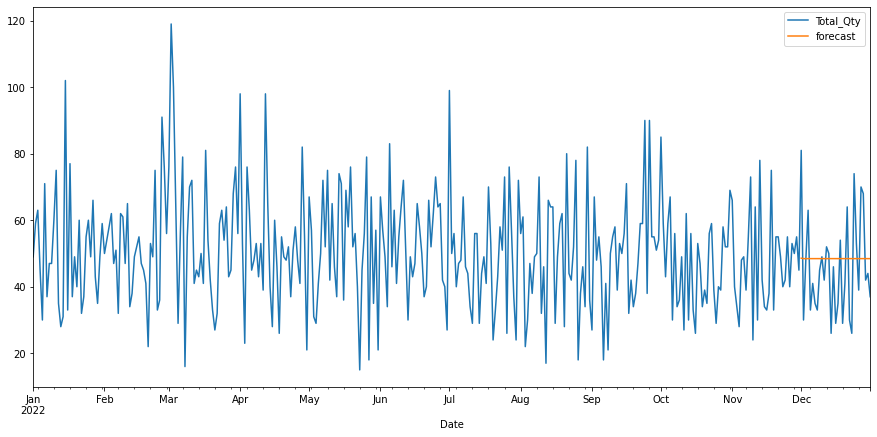

In [99]:
model_df['forecast'] = model_fit.predict(start='2022-12-01', end='2022-12-31', dynamic=True)
model_df[['Total_Qty', 'forecast']].plot(figsize=(15,7))
plt.show()

C:\Users\hp\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


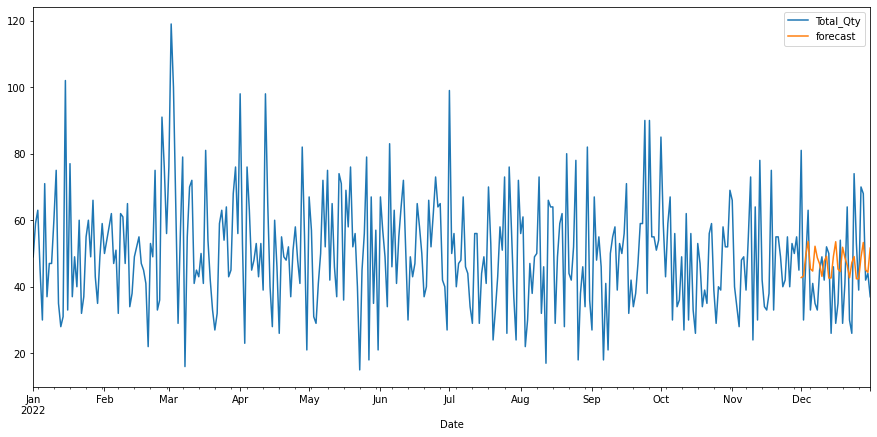

In [100]:
import statsmodels.api as sm    
model = sm.tsa.statespace.SARIMAX(model_df['Total_Qty'], order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit()
model_df['forecast'] = results.predict(start='2022-12-01',end='2022-12-31', dynamic=True)
model_df[['Total_Qty', 'forecast']].plot(figsize=(15,7));

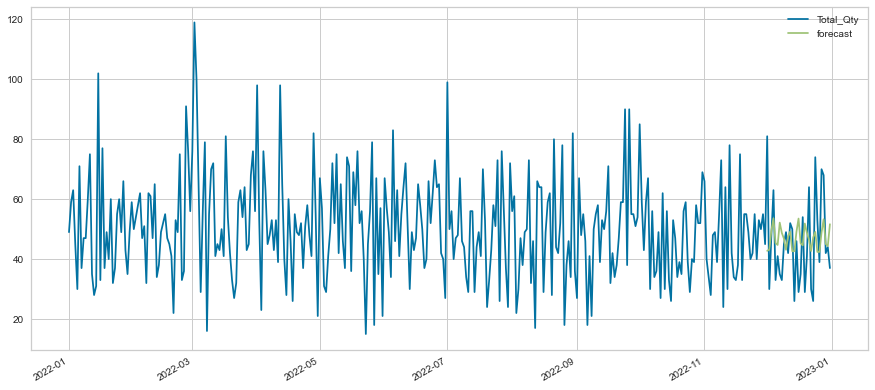

In [176]:
from pandas.tseries.offsets import DateOffset
future_dates = [model_df.index[-1]+ DateOffset(months=x) for x in range(0, 24)]
future_datest_df = pd.DataFrame(index=future_dates[1:], columns=model_df.columns)

future_datest_df.tail()

future_df = pd.concat([model_df, future_datest_df])

future_df['forecast'] = results.predict(start='2022-12-01', end='2022-12-31', dynamic=True)
future_df[['Total_Qty', 'forecast']].plot(figsize=(15, 7));

## Using Pycaret

In [103]:
from pycaret.time_series import * 
s = setup(model_df[['Total_Qty']], fh=3, fold=5, session_id=123, use_gpu=True)

,Description,Value
0,session_id,123
1,Target,Total_Qty
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(365, 1)"
5,Transformed data shape,"(365, 1)"
6,Transformed train set shape,"(362, 1)"
7,Transformed test set shape,"(3, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [104]:
best = compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
croston,Croston,0.7774,0.6883,14.5490,16.4778,0.3451,0.3229,-0.6771,0.0400
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.7919,0.6886,14.8200,16.4833,0.3638,0.3289,-0.6769,0.1820
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.7938,0.6965,14.8542,16.6743,0.3815,0.3290,-0.9523,6.0500
exp_smooth,Exponential Smoothing,0.7938,0.6872,14.8549,16.4509,0.3707,0.3296,-0.7118,0.0860
ets,ETS,0.7948,0.6878,14.8736,16.4650,0.3716,0.3299,-0.7198,0.1580
polytrend,Polynomial Trend Forecaster,0.7951,0.6880,14.8802,16.4699,0.3715,0.3301,-0.7203,0.0540
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.7953,0.6880,14.8830,16.4714,0.3717,0.3301,-0.7212,0.1980
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.7956,0.6882,14.8881,16.4755,0.3719,0.3302,-0.7217,0.2040
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.8010,0.6977,14.9870,16.7030,0.3940,0.3314,-0.9991,0.2040
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.8012,0.6918,14.9931,16.5601,0.3750,0.3324,-0.7325,0.1920


Processing:   0%|          | 0/113 [00:00<?, ?it/s]

c:\Users\hp\anaconda3\envs\Pycaret2\lib\site-packages\pycaret\internal\pycaret_experiment\supervised_experiment.py:711: UserWarning: Unsupported estimator `ensemble_forecaster` for method `compare_models()`, removing from model_library
  warnings.warn(
Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at 

In [112]:
# analyze model
plot_model(best, plot='forecast', data_kwargs={'fh':24})

In [114]:
plot_model(best, plot='diagnostics')

In [116]:
plot_model(best, plot='insample')

In [117]:
# tuned model
tuned_model = tune_model(best)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2022-12-13,0.7018,0.6590,13.1135,15.7962,0.4764,0.3524,-2.2173
1,2022-12-16,0.5123,0.4458,9.5789,10.6729,0.2417,0.2393,-0.0031
2,2022-12-19,0.6501,0.6510,12.1457,15.5597,0.2474,0.2690,-0.2065
3,2022-12-22,1.0572,0.9104,19.7896,21.7664,0.4177,0.4208,-0.2274
4,2022-12-25,0.8891,0.7247,16.6848,17.3711,0.2787,0.3020,-0.5038
Mean,NaT,0.7621,0.6782,14.2625,16.2333,0.3324,0.3167,-0.6316
SD,NaT,0.1907,0.1491,3.5820,3.5629,0.0963,0.0642,0.8087


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   19.8s finished


In [122]:
plot_model(tuned_model, plot='forecast', data_kwargs={'fh':24})

In [123]:
plot_model(tuned_model, plot='insample')

In [124]:
final_best = finalize_model(tuned_model)
results_pycaret = predict_model(tuned_model, fh = 24)

In [126]:
results_pycaret

,y_pred
2022-12-29,56.94
2022-12-30,56.94
2022-12-31,56.94
2023-01-01,56.94
2023-01-02,56.94
2023-01-03,56.94
2023-01-04,56.94
2023-01-05,56.94
2023-01-06,56.94
2023-01-07,56.94


In [127]:
predict_model(best, fh=24)

,y_pred
2022-12-29,49.17
2022-12-30,49.17
2022-12-31,49.17
2023-01-01,49.17
2023-01-02,49.17
2023-01-03,49.17
2023-01-04,49.17
2023-01-05,49.17
2023-01-06,49.17
2023-01-07,49.17


## Multiple Time Series Forecasting with PyCaret

In [149]:
model_df2 = model_df[['Total_Qty']].reset_index().copy()

Prepare dataset

In [152]:
model_df2['month'] = model_df2['Date'].dt.month
model_df2['year'] = model_df2['Date'].dt.year
model_df2['day_of_week'] = model_df2['Date'].dt.day_of_week
model_df2['day_of_year'] = model_df2['Date'].dt.day_of_year

In [153]:
model_df2.head()

,Date,Total_Qty,month,year,day_of_week,day_of_year
0,2022-01-01,49,1,2022,5,1
1,2022-01-02,59,1,2022,6,2
2,2022-01-03,63,1,2022,0,3
3,2022-01-04,45,1,2022,1,4
4,2022-01-05,30,1,2022,2,5


In [154]:
# check the unique the time series
model_df2['Date'].nunique()

365

Visualize time-series

In [156]:
import plotly.express as px  

model_df2['moving_average'] = model_df2['Total_Qty'].rolling(30).mean()
fig = px.line(model_df2, x='Date', y=['Total_Qty', 'moving_average'], title='Moving average', template='plotly_dark')
fig.show()

In [158]:
from pycaret.regression import * 

In [160]:
s = setup(model_df2.drop(columns='moving_average'), target='Total_Qty', session_id=123, use_gpu=True)

,Description,Value
0,Session id,123
1,Target,Total_Qty
2,Target type,Regression
3,Original data shape,"(365, 6)"
4,Transformed data shape,"(365, 8)"
5,Transformed train set shape,"(255, 8)"
6,Transformed test set shape,"(110, 8)"
7,Numeric features,4
8,Date features,1
9,Preprocess,True


In [164]:
best2 = compare_models()

Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already speci

In [166]:
# generate predictions on the original dataset
predictions = predict_model(best2, data=model_df2.drop(columns='moving_average'))


In [171]:
fig = px.line(predictions, x='Date', y=['Total_Qty', 'prediction_label'], template='plotly_dark')
fig.add_vrect(x0='2022-12-01', x1='2022-12-31', fillcolor='grey', opacity=0.25, line_width=0)
fig.show()

In [174]:
predictions.head()

,Date,month,year,day_of_week,day_of_year,Total_Qty,prediction_label
0,2022-01-01,1,2022,5,1,49,53.37
1,2022-01-02,1,2022,6,2,59,53.35
2,2022-01-03,1,2022,0,3,63,53.34
3,2022-01-04,1,2022,1,4,45,53.32
4,2022-01-05,1,2022,2,5,30,53.31


In [177]:
final_best2 = finalize_model(best2)

#### Creating a future scoring dataset

In [191]:
future_dates = pd.date_range(start='2023-01-01', end='2023-03-30', freq='MS')

future_df = pd.DataFrame()

future_df['Date'] = future_dates
future_df['month'] = [i.month for i in future_dates]
future_df['year'] = [i.year for i in future_dates]
future_df['day_of_week'] = [i.day_of_week for i in future_dates]
future_df['day_of_year'] = [i.day_of_year for i in future_dates]
future_df['Series'] = np.arange(145,(145+len(future_dates)))

future_df.head()

,Date,month,year,day_of_week,day_of_year,Series
0,2023-01-01,1,2023,6,1,145
1,2023-02-01,2,2023,2,32,146
2,2023-03-01,3,2023,2,60,147


In [192]:
predictions_future = predict_model(final_best2, data=future_df)
predictions_future.head()

,Date,month,year,day_of_week,day_of_year,Series,prediction_label
0,2023-01-01,1,2023,6,1,145,53.46
1,2023-02-01,2,2023,2,32,146,52.90
2,2023-03-01,3,2023,2,60,147,52.39


In [193]:
concat_df = pd.concat([model_df2.drop(columns='moving_average'), predictions_future], axis=0)

fig = px.line(concat_df, x='Date', y=['Total_Qty', 'prediction_label'], template='plotly_dark')
fig.show()